In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import gymnasium as gym
import matplotlib.pyplot as plt
import seaborn as sns
import random
from gymnasium.wrappers import RecordVideo

In [32]:
class ReplayBuffer:
    def __init__(self, capacity, n_step, gamma, device):
        self.capacity = capacity
        self.n_step = n_step
        self.gamma = gamma
        self.memory = deque(maxlen=self.capacity)
        self.n_step_buffer = deque(maxlen=self.n_step)
        self.device = device

    def _get_n_step_info(self):
        reward, next_state, done = self.n_step_buffer[-1][-3:]
        for _, _, rew, next_s, do in reversed(list(self.n_step_buffer)[:-1]):
            reward = self.gamma * reward * (1 - do) + rew
            reward, next_state, done = (rew, next_s, do) if do else (reward, next_state, done)
        return reward, next_state, done

    def store(self, state, action, reward, next_state, done):
        self.n_step_buffer.append((state, action, reward, next_state, done))
        if len(self.n_step_buffer) < self.n_step:
            return
        reward, next_state, done = self._get_n_step_info()
        state, action = self.n_step_buffer[0][:2]
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):            
        batch_idxs = np.random.choice(len(self.memory), replace=False, size=batch_size)
        batch = [self.memory[i] for i in batch_idxs]
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float32)
        action_batch = torch.tensor(action_batch, device=self.device).unsqueeze(1)
        reward_batch = torch.tensor(reward_batch, device=self.device, dtype=torch.float32)
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float32)
        done_batch = torch.tensor(done_batch, device=self.device, dtype=torch.int)
        
        return state_batch, action_batch, reward_batch, next_state_batch, done_batch

    def clear(self):
        self.memory.clear()

In [33]:
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(self.state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, self.action_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class DuelingQNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.fc1 = nn.Linear(self.state_dim, hidden_dim)

        self.adv_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.adv_fc3 = nn.Linear(hidden_dim, self.action_dim)

        self.value_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.value_fc3 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        feature = self.fc1(x)
        # 计算V(s)
        advantage = F.relu(feature)
        advantage = self.value_fc2(advantage)
        advantage = F.relu(advantage)
        advantage = self.value_fc3(advantage)

        # 计算A(s,a)
        value = F.relu(feature)
        value = self.adv_fc2(value)
        value = F.relu(value)
        value = self.adv_fc3(value)

        return value + advantage - advantage.mean()
    
    
class NoisyLinear(nn.Module):
    def __init__(self, input_dim, output_dim, std_init=0.5):
        super(NoisyLinear, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.FloatTensor(self.output_dim, self.input_dim))
        self.weight_sigma = nn.Parameter(torch.FloatTensor(self.output_dim, self.input_dim))
        self.register_buffer('weight_epsilon', torch.FloatTensor(self.output_dim, self.input_dim))

        self.bias_mu = nn.Parameter(torch.FloatTensor(self.output_dim))
        self.bias_sigma = nn.Parameter(torch.FloatTensor(self.output_dim))
        self.register_buffer('bias_epsilon', torch.FloatTensor(self.output_dim))

        self.reset_parameter()
        self.reset_noise()

    def forward(self, input):
        if self.training:
            weight = self.weight_mu + self.weight_sigma.mul(self.weight_epsilon)
            bias = self.bias_mu + self.bias_sigma.mul(self.bias_epsilon)
        else:
            weight = self.weight_mu
            bias = self.bias_mu
        return F.linear(input, weight, bias)

    def reset_parameter(self):
        mu_range = 1 / np.sqrt(self.input_dim)

        self.weight_mu.detach().uniform_(-mu_range, mu_range)
        self.bias_mu.detach().uniform_(-mu_range, mu_range)

        self.weight_sigma.detach().fill_(self.std_init / np.sqrt(self.input_dim))
        self.bias_sigma.detach().fill_(self.std_init / np.sqrt(self.output_dim))

    def _scale_noise(self, size):
        noise = torch.randn(size)
        noise = noise.sign().mul(noise.abs().sqrt())
        return noise

    def reset_noise(self):
        epsilon_in = self._scale_noise(self.input_dim)
        epsilon_out = self._scale_noise(self.output_dim)

        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(self._scale_noise(self.output_dim))


class NoisyQNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.fc = nn.Linear(self.state_dim, hidden_dim)
        self.noisy1 = NoisyLinear(hidden_dim, hidden_dim)
        self.noisy2 = NoisyLinear(hidden_dim, self.action_dim)

    def forward(self, x):
        x = self.fc(x)
        x = F.relu(x)
        x = self.noisy1(x)
        x = F.relu(x)
        x = self.noisy2(x)
        return x

    def reset_noise(self):
        self.noisy1.reset_noise()
        self.noisy2.reset_noise()

In [34]:
class Agent:
    def __init__(self,method_name, target_model, policy_model, memory, is_double, n_step, is_epsilonDecay, is_lrScheduler, args):
        self.memory = memory
        self.n_step = n_step
        self.is_epsilonDecay = is_epsilonDecay
        self.is_double = is_double
        self.is_lrScheduler = is_lrScheduler
        
        self.name = args.env_name + '_' + method_name
        self.state_dim = args.state_dim
        self.action_dim = args.action_dim
        self.device = args.device
        self.gamma = args.gamma
        if self.is_epsilonDecay:
            self.epsilon = args.epsilon_start
            self.epsilon_start = args.epsilon_start
            self.epsilon_end = args.epsilon_end
            self.epsilon_decay = args.epsilon_decay
        else:
            self.epsilon = args.epsilon_end
            
        self.batch_size = args.batch_size
        self.lr = args.lr


        self.optimizer = torch.optim.Adam(policy_model.parameters(), lr=self.lr)
        if self.is_lrScheduler:
            self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 'min', patience=10000, verbose=True)
        self.loss_func = nn.MSELoss()
        self.target_net = target_model.to(self.device)
        self.policy_net = policy_model.to(self.device)
        self.best_net_para = self.policy_net.state_dict()
        for target_param, param in zip(self.target_net.parameters(), self.policy_net.parameters()):
            target_param.data.copy_(param.data)

    @torch.no_grad()
    def get_action(self, state):
        state = torch.tensor(state, dtype=torch.float).to(self.device)
        if np.random.random() > self.epsilon:
            q_value = self.policy_net(state)
            action = q_value.argmax().item()
        else:
            action = np.random.randint(self.action_dim)
        return action

    def learn(self):
        if self.is_epsilonDecay and self.epsilon > self.epsilon_end:
            self.epsilon *= self.epsilon_decay

        if len(self.memory.memory) < self.batch_size:  # 当经验回放中不满足一个批量时，不更新策略
            return

        self.optimizer.zero_grad()
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = self.memory.sample(self.batch_size)
        q_values = self.policy_net(state_batch).gather(dim=1, index=action_batch)
        if not self.is_double:
            next_q_values = self.target_net(next_state_batch).max(1)[0].detach()
        else:
            next_actions = self.policy_net(state_batch).max(1)[1].detach().unsqueeze(1)
            next_q_values = self.target_net(next_state_batch).gather(dim=1, index=next_actions).squeeze(1)
        expected_q_values = reward_batch + (self.gamma ** self.n_step) * next_q_values * (1 - done_batch)
        loss = self.loss_func(q_values, expected_q_values.unsqueeze(1))
        loss.backward()
        self.optimizer.step()
        if self.is_lrScheduler:
            self.scheduler.step(loss)

    def train(self, env, args):
        print('******开始训练！******')
        rewards = []
        max_reward = 0
        for i_ep in range(args.train_eps):
            ep_reward = 0
            state, info = env.reset()
            if isinstance(self.policy_net, NoisyQNet):
                self.policy_net.reset_noise()
            if i_ep % args.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())
            for _ in range(args.train_ep_max_steps):
                action = self.get_action(state)
                next_state, reward, done, truncated, info = env.step(action)
                self.memory.store(state, action, reward, next_state, done)
                state = next_state
                self.learn()
                ep_reward += reward
                if done:
                    break
            if i_ep % 50 == 0:
                print(f"回合：{i_ep + 1}/{args.train_eps}，奖励：{ep_reward:.2f}，Epislon：{self.epsilon:.3f}")
            rewards.append(ep_reward)
            if ep_reward > max_reward:
                self.best_net_para = self.policy_net.state_dict()
                max_reward = ep_reward
        return rewards

    def test(self, env, args):
        print('******开始测试！******')
        rewards = []
        self.policy_net.load_state_dict(self.best_net_para)
        for i_ep in range(args.test_eps):
            ep_reward = 0
            state, info = env.reset()
            for _ in range(args.test_ep_max_steps):
                action = self.policy_net(torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)).argmax().item()
                next_state, reward, done, _ ,_= env.step(action)
                state = next_state
                ep_reward += reward
                if done:
                    break
            rewards.append(ep_reward)
        return rewards


In [35]:
def plot_rewards(name_rewards, args, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure() 
    plt.title(f"{tag}ing curve on {args.device} for {args.env_name}")
    plt.xlabel('epsiodes')
    for name in name_rewards:
        plt.plot(smooth(name_rewards[name]), label=name)
    plt.legend()
    plt.savefig(tag+'.jpg')
    plt.show()

def smooth(data, weight=0.9):
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0]
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed


******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.010
回合：51/500，奖励：-500.00，Epislon：0.010
回合：101/500，奖励：-500.00，Epislon：0.010
回合：151/500，奖励：-402.00，Epislon：0.010
回合：201/500，奖励：-500.00，Epislon：0.010
回合：251/500，奖励：-335.00，Epislon：0.010
回合：301/500，奖励：-500.00，Epislon：0.010
回合：351/500，奖励：-500.00，Epislon：0.010
回合：401/500，奖励：-500.00，Epislon：0.010
回合：451/500，奖励：-425.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_origin\rl-video-episode-8.mp4
******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.546
回合：51/500，奖励：-500.00，Epislon：0.010
回合：101/500，奖励：-500.00，Epislon：0.010
回合：151/500，奖励：-500.00，Epislon：0.010
回合：201/500，奖励：-500.00，Epislon：0.010
回合：251/500，奖励：-500.00，Epislon：0.010
回合：301/500，奖励：-500.00，Epislon：0.010
回合：351/500，奖励：-500.00，Epislon：0.010
回合：401/500，奖励：-500.00，Epislon：0.010
回合：451/500，奖励：-500.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_epsilonDecay\rl-video-episode-8.mp4
******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.010
回合：51/500，奖励：-500.00，Epislon：0.010
回合：101/500，奖励：-303.00，Epislon：0.010
回合：151/500，奖励：-248.00，Epislon：0.010
回合：201/500，奖励：-268.00，Epislon：0.010
回合：251/500，奖励：-163.00，Epislon：0.010
回合：301/500，奖励：-126.00，Epislon：0.010
回合：351/500，奖励：-161.00，Epislon：0.010
回合：401/500，奖励：-211.00，Epislon：0.010
回合：451/500，奖励：-102.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-0.mp4



Moviepy - Done !


Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-1.mp4



Moviepy - Done !


Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-8.mp4



Moviepy - Done !


Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_4step\rl-video-episode-8.mp4
******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.010
回合：51/500，奖励：-500.00，Epislon：0.010
Epoch 26221: reducing learning rate of group 0 to 1.0000e-04.
Epoch 36222: reducing learning rate of group 0 to 1.0000e-05.
Epoch 46223: reducing learning rate of group 0 to 1.0000e-06.
回合：101/500，奖励：-500.00，Epislon：0.010
Epoch 56224: reducing learning rate of group 0 to 1.0000e-07.
Epoch 66225: reducing learning rate of group 0 to 1.0000e-08.
回合：151/500，奖励：-500.00，Epislon：0.010
回合：201/500，奖励：-500.00，Epislon：0.010
回合：251/500，奖励：-500.00，Epislon：0.010
回合：301/500，奖励：-500.00，Epislon：0.010
回合：351/500，奖励：-500.00，Epislon：0.010
回合：401/500，奖励：-500.00，Epislon：0.010
回合：451/500，奖励：-500.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_lrScheduler\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士

Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_lrScheduler\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_lrScheduler\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_lrScheduler\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_lrScheduler\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_lrScheduler\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_lrScheduler\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn_lrScheduler\rl-video-episode-8.mp4
******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.010
回合：51/500，奖励：-500.00，Epislon：0.010
回合：101/500，奖励：-500.00，Epislon：0.010
回合：151/500，奖励：-500.00，Epislon：0.010
回合：201/500，奖励：-500.00，Epislon：0.010
回合：251/500，奖励：-482.00，Epislon：0.010
回合：301/500，奖励：-228.00，Epislon：0.010
回合：351/500，奖励：-206.00，Epislon：0.010
回合：401/500，奖励：-365.00，Epislon：0.010
回合：451/500，奖励：-305.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_noisydqn\rl-video-episode-8.mp4


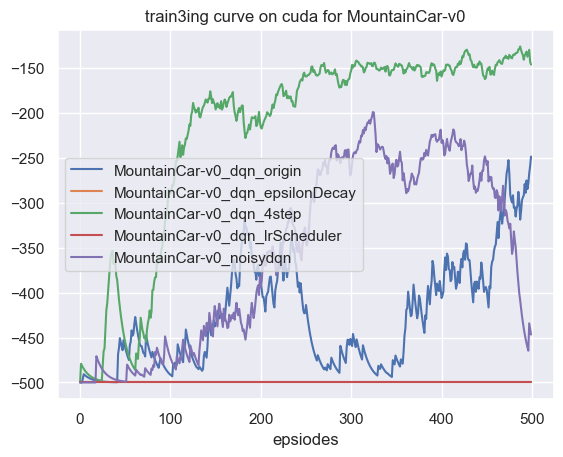

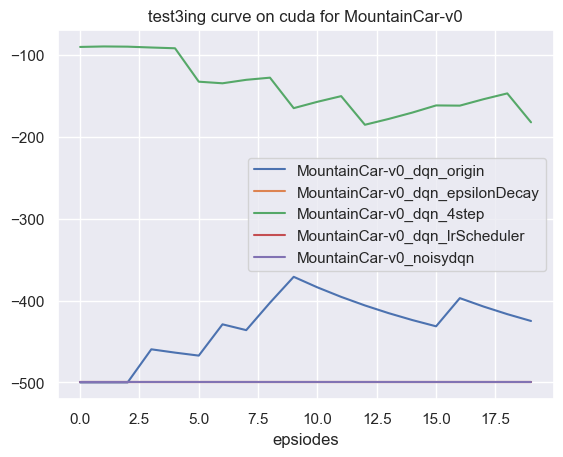

******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.010
回合：51/500，奖励：-500.00，Epislon：0.010
回合：101/500，奖励：-376.00，Epislon：0.010
回合：151/500，奖励：-254.00，Epislon：0.010
回合：201/500，奖励：-500.00，Epislon：0.010
回合：251/500，奖励：-332.00，Epislon：0.010
回合：301/500，奖励：-500.00，Epislon：0.010
回合：351/500，奖励：-383.00，Epislon：0.010
回合：401/500，奖励：-150.00，Epislon：0.010
回合：451/500，奖励：-337.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_dqn\rl-video-episode-8.mp4
******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.010
回合：51/500，奖励：-500.00，Epislon：0.010
回合：101/500，奖励：-500.00，Epislon：0.010
回合：151/500，奖励：-500.00，Epislon：0.010
回合：201/500，奖励：-500.00，Epislon：0.010
回合：251/500，奖励：-500.00，Epislon：0.010
回合：301/500，奖励：-500.00，Epislon：0.010
回合：351/500，奖励：-500.00，Epislon：0.010
回合：401/500，奖励：-500.00，Epislon：0.010
回合：451/500，奖励：-259.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_dqn\rl-video-episode-8.mp4
******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.010
回合：51/500，奖励：-500.00，Epislon：0.010
回合：101/500，奖励：-500.00，Epislon：0.010
回合：151/500，奖励：-500.00，Epislon：0.010
回合：201/500，奖励：-500.00，Epislon：0.010
回合：251/500，奖励：-500.00，Epislon：0.010
回合：301/500，奖励：-500.00，Epislon：0.010
回合：351/500，奖励：-500.00，Epislon：0.010
回合：401/500，奖励：-500.00，Epislon：0.010
回合：451/500，奖励：-500.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_duelingdqn\rl-video-episode-8.mp4
******开始训练！******
回合：1/500，奖励：-500.00，Epislon：0.010
回合：51/500，奖励：-500.00，Epislon：0.010
回合：101/500，奖励：-466.00，Epislon：0.010
回合：151/500，奖励：-255.00，Epislon：0.010
回合：201/500，奖励：-500.00，Epislon：0.010
回合：251/500，奖励：-192.00，Epislon：0.010
回合：301/500，奖励：-220.00，Epislon：0.010
回合：351/500，奖励：-308.00，Epislon：0.010
回合：401/500，奖励：-302.00，Epislon：0.010
回合：451/500，奖励：-149.00，Epislon：0.010
******开始测试！******
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-0.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-0.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-1.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-1.mp4



Moviepy - Done !


Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-1.mp4
Moviepy - Building video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-8.mp4.
Moviepy - Writing video c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready c:\Users\YovRen\Desktop\硕士课程\强化学习\RL-exp2\video\MountainCar-v0_double_duelingdqn\rl-video-episode-8.mp4


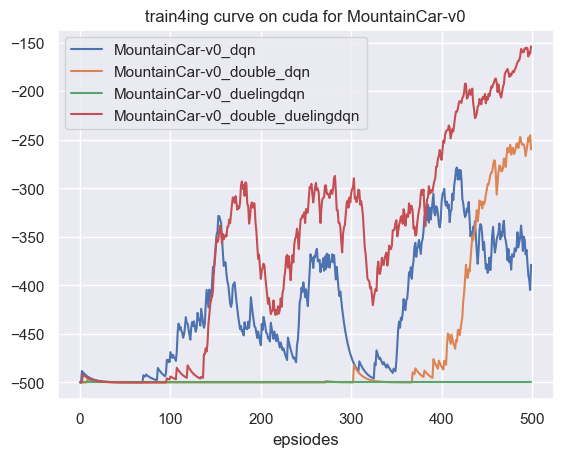

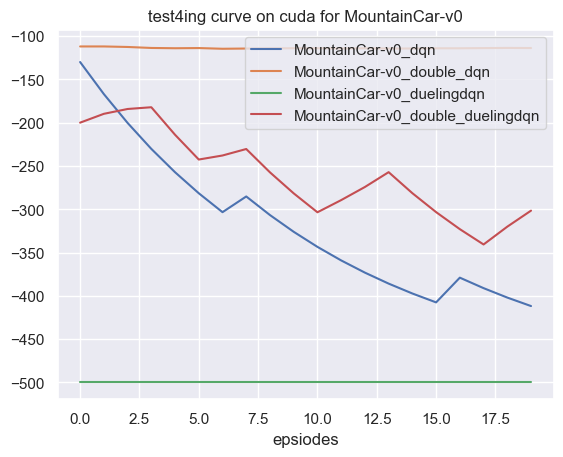

In [36]:
class Args:
    def __init__(self):
        # 环境相关参数
        self.env_name = 'MountainCar-v0'
        # self.env_name = 'CartPole-v1'
        self.state_dim = 0
        self.action_dim = 0

        # 经验回放池相关参数
        self.capacity = 100000

        self.epsilon_start = 0.9
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.999

        # 智能体相关参数
        self.gamma = 0.95
        self.lr = 0.001
        self.target_update = 5

        # 训练相关参数
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.batch_size = 64
        self.train_eps = 500
        self.test_eps = 20
        self.train_ep_max_steps = 500
        self.test_ep_max_steps = 500


if __name__ == '__main__':
    args = Args()
    np.random.seed(1)
    torch.manual_seed(1)
    torch.cuda.manual_seed(1)

    env = gym.make(args.env_name)
    args.state_dim = env.observation_space.shape[0]
    args.action_dim = env.action_space.n

    dqn_origin = Agent('dqn_origin',
                       QNet(args.state_dim, args.action_dim),
                       QNet(args.state_dim, args.action_dim),
                       ReplayBuffer(args.capacity, 1, args.gamma, args.device),
                       False, 1, False, False, args)
    dqn_epsilonDecay = Agent('dqn_epsilonDecay',
                               QNet(args.state_dim, args.action_dim),
                               QNet(args.state_dim, args.action_dim),
                               ReplayBuffer(args.capacity, 1,  args.gamma, args.device),
                               False, 1, True, False, args)
    dqn_4step = Agent('dqn_4step',
                       QNet(args.state_dim, args.action_dim),
                       QNet(args.state_dim, args.action_dim),
                       ReplayBuffer(args.capacity, 4, args.gamma, args.device),
                       False, 4, False, False, args)
    dqn_lrScheduler = Agent('dqn_lrScheduler',
                            QNet(args.state_dim, args.action_dim),
                            QNet(args.state_dim, args.action_dim),
                            ReplayBuffer(args.capacity, 1, args.gamma, args.device),
                            False, 1, False, True, args)
    noisydqn = Agent('noisydqn',
                     NoisyQNet(args.state_dim, args.action_dim),
                     NoisyQNet(args.state_dim, args.action_dim),
                     ReplayBuffer(args.capacity, 1, args.gamma, args.device),
                     False, 1, False, False, args)
    name_rewards_train = {}
    name_rewards_test = {}
    for agent in [dqn_origin, dqn_epsilonDecay, dqn_4step, dqn_lrScheduler, noisydqn]:
        env = gym.make(args.env_name)
        name_rewards_train[agent.name] = agent.train(env, args)
        env = gym.make(args.env_name, render_mode="rgb_array")
        name_rewards_test[agent.name] = agent.test(
            RecordVideo(env, './video/'+agent.name), args)
    plot_rewards(name_rewards_train, args, tag="train3")
    plot_rewards(name_rewards_test, args, tag="test3")

    dqn = Agent('dqn',
                QNet(args.state_dim, args.action_dim),
                QNet(args.state_dim, args.action_dim),
                ReplayBuffer(args.capacity, 1, args.gamma, args.device),
                False, 1, False, False, args)
    double_dqn = Agent('double_dqn',
                       QNet(args.state_dim, args.action_dim),
                       QNet(args.state_dim, args.action_dim),
                       ReplayBuffer(args.capacity, 1, args.gamma, args.device),
                       True, 1, False, False, args)
    duelingdqn = Agent('duelingdqn',
                       DuelingQNet(args.state_dim, args.action_dim),
                       DuelingQNet(args.state_dim, args.action_dim),
                       ReplayBuffer(args.capacity, 1, args.gamma, args.device),
                       False, 1, False, False, args)
    double_duelingdqn = Agent('double_duelingdqn',
                              DuelingQNet(args.state_dim, args.action_dim),
                              DuelingQNet(args.state_dim, args.action_dim),
                              ReplayBuffer(args.capacity, 1,
                                           args.gamma, args.device),
                              True, 1, False, False, args)

    name_rewards_train = {}
    name_rewards_test = {}
    for agent in [dqn, double_dqn, duelingdqn, double_duelingdqn]:
        env = gym.make(args.env_name)
        name_rewards_train[agent.name] = agent.train(env, args)
        env = gym.make(args.env_name, render_mode="rgb_array")
        name_rewards_test[agent.name] = agent.test(
            RecordVideo(env, './video/'+agent.name), args)
    plot_rewards(name_rewards_train, args, tag="train4")
    plot_rewards(name_rewards_test, args, tag="test4")
